In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from sklearn.linear_model import LogisticRegression
import scipy.stats as sps
%matplotlib inline
from matplotlib import pylab
pylab.rcParams['figure.figsize']=(12,12)

def shuffler(filename):
    """
    Read into dataframe and shuffle
    """
    df = pd.read_csv(filename, header=0)
    # return the pandas dataframe
    return df.reindex(np.random.permutation(df.index))

In [3]:
phot_df_raw = shuffler('phot_ext_rgilmore.csv')
phot_df_raw.shape

(88943, 370)

# Data Preparation

In [4]:
# Apply some cuts on the data
#Nonphysical model outputs
phot_df = phot_df_raw[phot_df_raw['deVRad_r']>=0.0]
phot_df = phot_df[phot_df['expRad_g']>=0.0]
phot_df = phot_df[phot_df['expAB_g']>=0.]
phot_df = phot_df[phot_df['deVAB_z']>=0.]


# Redshift limits
phot_df = phot_df[(phot_df.z<0.5) & (phot_df.z>0.0)] 



# Remove high extinction cases
phot_df = phot_df[phot_df.extinction_u<=0.5]

# Nonphysical flux params within models
phot_df = phot_df[(phot_df.aperFlux7_g>0)\
                  &(phot_df.cModelFlux_g>0)\
                  &(phot_df.expFlux_u>0)\
                  &(phot_df.modelFlux_u>0)] #check that no negative linear flux params appear
phot_df.reset_index(inplace=True)
phot_df.shape

(85365, 371)

In [5]:
# Extinction corrections to flux

flux_col_lst = [col_name for col_name in phot_df.columns if 'Flux' in col_name]
#print flux_col_list
#print phot_df[flux_col_list][0:10]
             
for flux_col in flux_col_lst:
    band = flux_col[-1]
    phot_df[flux_col+'_ext_cor']=phot_df[flux_col]*2.5**phot_df['extinction_'+band]

In [6]:
phot_df[['psfFlux_u','psfFlux_u_ext_cor','extinction_u']][0:3]

,psfFlux_u,psfFlux_u_ext_cor,extinction_u
0,5.392266,6.092167,0.133187
1,11.651980,14.735150,0.256207
2,3.295182,3.399180,0.033911


In [7]:
# Extinction corrections to magnitude measurements

mag_col_lst = [col_name for col_name in phot_df.columns if 'Mag' in col_name and 'Err' not in col_name]

             
for mag_col in mag_col_lst:
    band = mag_col[-1]
    phot_df[mag_col+'_ext_cor']=phot_df[mag_col]-phot_df['extinction_'+band]
    

In [8]:
phot_df[['deVMag_u','deVMag_u_ext_cor','extinction_u']][0:3]

,deVMag_u,deVMag_u_ext_cor,extinction_u
0,17.94083,17.807643,0.133187
1,18.04582,17.789614,0.256207
2,17.65740,17.623489,0.033911


In [9]:
# remove unextincted columns
print len(phot_df.columns)
for flux_col in flux_col_lst:
    phot_df.drop(flux_col,inplace=True,axis=1)
    
for mag_col in mag_col_lst:
    phot_df.drop(mag_col,inplace=True,axis=1)
print len(phot_df.columns)

501
371


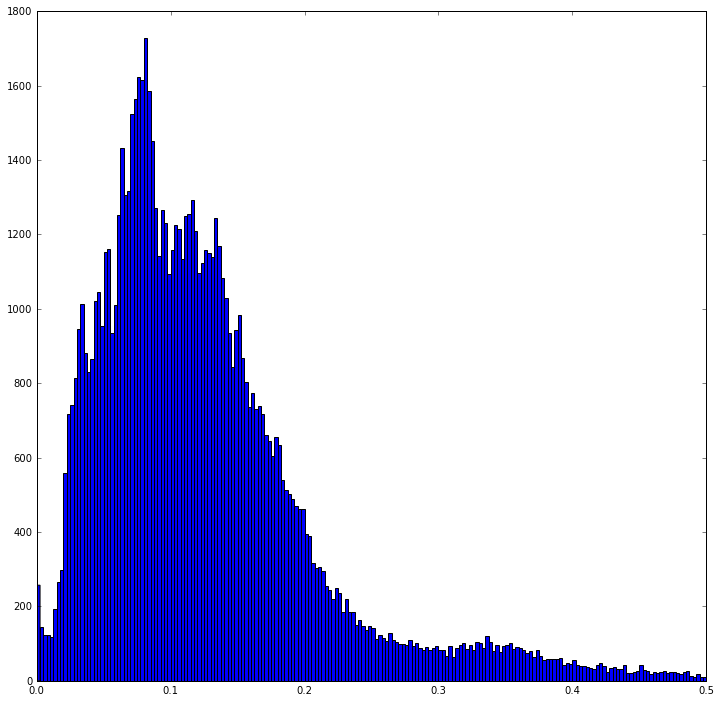

In [10]:
#redshift (distance) distro of galaxy targets
xx=plt.hist(phot_df.z,200)

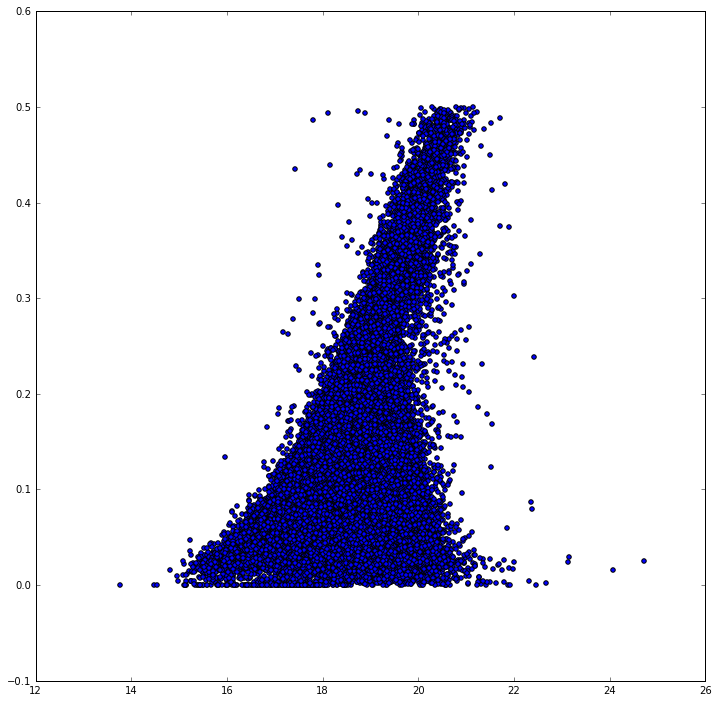

In [11]:
#xx=plt.hist(phot_df.petroMag_r,100)
xx = plt.scatter(phot_df.psfMag_r_ext_cor,phot_df.z)

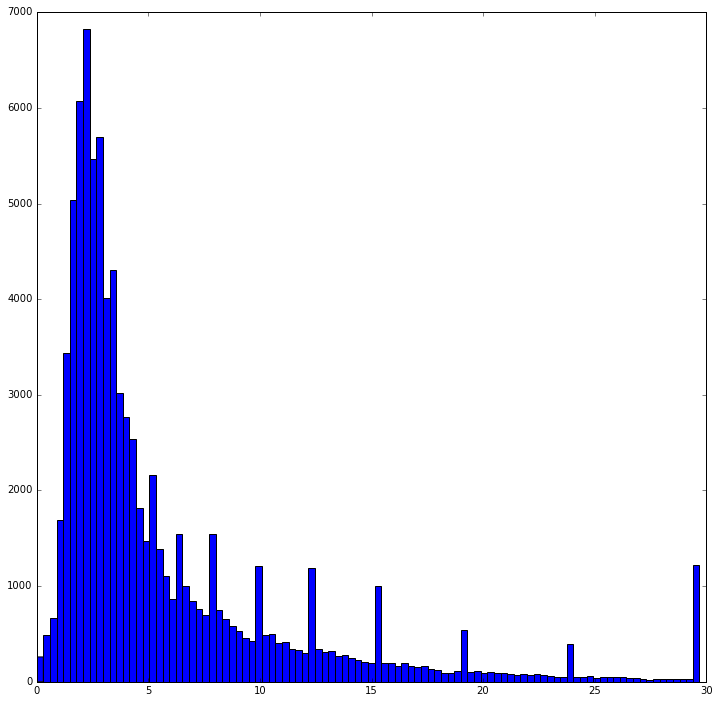

In [12]:
#radius fit distro
xx=plt.hist(phot_df.deVRad_g,100)


In [13]:
# Our target variables 
phot_df[['deVRad_r','p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_cs']].head()


,deVRad_r,p_el,p_cw,p_acw,p_edge,p_dk,p_mg,p_cs
0,16.466460,0.129,0.022,0.003,0.708,0.063,0.074,0.733
1,2.978688,0.938,0.005,0.007,0.032,0.018,0.000,0.044
2,29.666960,0.018,0.002,0.002,0.968,0.007,0.002,0.973
3,2.183182,0.858,0.008,0.021,0.072,0.041,0.000,0.101
4,2.635650,0.898,0.003,0.013,0.045,0.037,0.005,0.060


(-0.35639567665324889, 0.0)


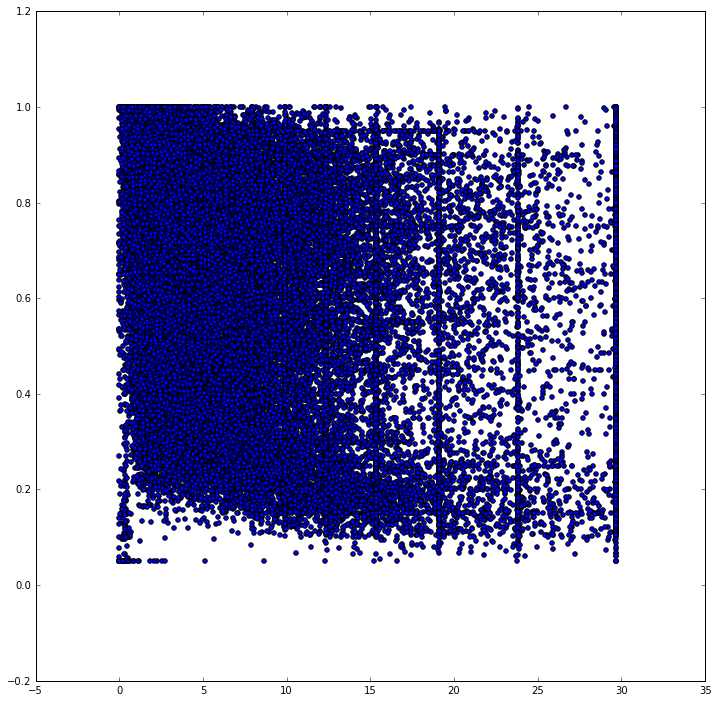

In [213]:
x,y = phot_df['deVRad_g'],phot_df['deVAB_i']
print sps.pearsonr(x,y)
plt.scatter(x,y)

# Logistic Regression

In [14]:
# For the first modeling attempt, let's identify a subset of parameters which are highly correlated with the target
# variables
res=[]
for col in phot_df.columns:
    if 'p_' not in col: res.append([col]+list(sps.pearsonr(phot_df.p_cs,phot_df[col]))) #all independent vars

out = sorted(res,key=lambda x:np.absolute(x[1]),reverse=True)
for item in out[0:50]:
    print item  #variables sorted by declining correlation
    #if 'p_' not in item[0]: print item

['deVRad_g', 0.72697382033133817, 0.0]
['deVRad_r', 0.69263060921868824, 0.0]
['deVRad_i', 0.67852878609926193, 0.0]
['deVRad_z', 0.67444338949538984, 0.0]
['fracDeV_g', -0.66555127811401182, 0.0]
['fracDeV_r', -0.65412898164934241, 0.0]
['fracDeV_i', -0.63377377936897417, 0.0]
['expRad_g', 0.62432872211784951, 0.0]
['expRad_r', 0.58603216465984986, 0.0]
['fracDeV_z', -0.580696247501992, 0.0]
['expRad_i', 0.57649779553643021, 0.0]
['expRad_z', 0.57515337988697657, 0.0]
['fracDeV_u', -0.55719004524555316, 0.0]
['expAB_i', -0.54583176683460977, 0.0]
['expAB_z', -0.54525159464598594, 0.0]
['expAB_r', -0.54340837935255548, 0.0]
['expAB_g', -0.52923958432893337, 0.0]
['deVAB_z', -0.52550665088868098, 0.0]
['deVAB_i', -0.52391789795700749, 0.0]
['deVAB_r', -0.5210762817024932, 0.0]
['deVRad_u', 0.50941131249218641, 0.0]
['deVAB_g', -0.50393881864144907, 0.0]
['deVMag_u_ext_cor', -0.49334667573966723, 0.0]
['expMag_u_ext_cor', -0.48821692671485944, 0.0]
['expFluxIvar_z_ext_cor', -0.4358294957

In [15]:
# First attempt at a 2-category classifier: can we distinguish elliptical from non-ellipticals?

input_set = [item[0] for item in out[0:50] if 'p_' not in item[0]]
test_size = 10000

lm = LogisticRegression()
X = np.array(phot_df[input_set][test_size:])
y = np.array(phot_df['p_el'].apply(lambda x:int(x>0.8)))[test_size:]
X_pred = np.array(phot_df[input_set][:test_size])
y_pred = np.array(phot_df['p_el'].apply(lambda x:int(x>0.8)))[:test_size]
lm.fit(X,y)
res_df = phot_df[input_set][0:test_size-1] 
res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(phot_df[input_set][0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)


In [16]:
# Results here are encouraging, nearly 90% of the 10000-case sample classified correctly
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
res_df.head()

4545 4772 8902


,deVRad_g,deVRad_r,deVRad_i,deVRad_z,fracDeV_g,fracDeV_r,fracDeV_i,expRad_g,expRad_r,fracDeV_z,...,deVFluxIvar_r_ext_cor,petroRad_r,petroRad_g,cModelMag_g_ext_cor,petroMag_g_ext_cor,deVFlux_u_ext_cor,cModelFluxIvar_z_ext_cor,actual,pred,cor
0,15.557040,16.466460,16.080340,17.645940,0.000000,0.03184,0.028235,6.594556,6.657146,0.033636,...,0.220112,10.087100,9.602155,16.955262,17.004492,75.277593,0.031839,0,0,1
1,3.248952,2.978688,2.830017,2.803831,1.000000,1.00000,1.000000,2.270192,2.221646,1.000000,...,0.632164,5.887563,6.127900,16.502956,16.636826,76.493780,0.039708,1,1,1
2,29.676200,29.666960,28.583470,29.668400,0.000000,0.00000,0.000000,12.517440,11.776850,0.000000,...,0.175546,14.063530,14.647260,16.898778,16.982718,89.234393,0.016588,0,0,1
3,2.282174,2.183182,2.202491,2.202212,0.990887,1.00000,1.000000,1.539448,1.349775,1.000000,...,0.953396,4.569018,4.638682,17.131541,17.285831,33.866218,0.063324,1,1,1
4,2.722582,2.635650,2.540919,2.140477,1.000000,1.00000,1.000000,1.589576,1.601241,1.000000,...,0.817846,5.563691,5.661742,17.002412,17.067022,32.088578,0.062767,1,1,1


In [17]:
# We can code up a transition-matrix to look at counts predicted vs actual
imax = max(res_df.actual)
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) #rows are actual class, columns are predicted

,0,1
0,4792,662
1,435,4110


In [18]:
ycols = [col for col in phot_df.columns if 'p_' in col[:2]]

In [19]:
input_set = [item[0] for item in out[0:50] if 'p_' not in item[0][:2]]
test_size = 10000

ycols = [col for col in phot_df.columns if 'p_' in col[:2]]
def gal_class(row):
    for item in ycols:
        if row[item]>0.8:return item 
    return None

phot_df['gal_class'] = phot_df.apply(gal_class,axis=1)
mod_df = phot_df[phot_df.gal_class!=None]
len(mod_df)

lm = LogisticRegression()
X = np.array(phot_df[input_set][test_size:])
y = np.array(phot_df['p_el'].apply(lambda x:int(x>0.8)))[test_size:]
X_pred = np.array(phot_df[input_set][:test_size])
y_pred = np.array(phot_df['p_el'].apply(lambda x:int(x>0.8)))[:test_size]
lm.fit(X,y)
res_df = phot_df[input_set][0:test_size-1] 
res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(phot_df[input_set][0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
res_df.head()

4545 4774 8892


,deVRad_g,deVRad_r,deVRad_i,deVRad_z,fracDeV_g,fracDeV_r,fracDeV_i,expRad_g,expRad_r,fracDeV_z,...,deVFluxIvar_r_ext_cor,petroRad_r,petroRad_g,cModelMag_g_ext_cor,petroMag_g_ext_cor,deVFlux_u_ext_cor,cModelFluxIvar_z_ext_cor,actual,pred,cor
0,15.557040,16.466460,16.080340,17.645940,0.000000,0.03184,0.028235,6.594556,6.657146,0.033636,...,0.220112,10.087100,9.602155,16.955262,17.004492,75.277593,0.031839,0,0,1
1,3.248952,2.978688,2.830017,2.803831,1.000000,1.00000,1.000000,2.270192,2.221646,1.000000,...,0.632164,5.887563,6.127900,16.502956,16.636826,76.493780,0.039708,1,1,1
2,29.676200,29.666960,28.583470,29.668400,0.000000,0.00000,0.000000,12.517440,11.776850,0.000000,...,0.175546,14.063530,14.647260,16.898778,16.982718,89.234393,0.016588,0,0,1
3,2.282174,2.183182,2.202491,2.202212,0.990887,1.00000,1.000000,1.539448,1.349775,1.000000,...,0.953396,4.569018,4.638682,17.131541,17.285831,33.866218,0.063324,1,1,1
4,2.722582,2.635650,2.540919,2.140477,1.000000,1.00000,1.000000,1.589576,1.601241,1.000000,...,0.817846,5.563691,5.661742,17.002412,17.067022,32.088578,0.062767,1,1,1


# Multinomial classifier

In [20]:
# Now, let's attempt to distinguish elliptical, face on- and edge on-spirals, and mergers in a single model, using 
# the softmax regression feature in sklearn's Logistic Regression package.  Our target variables will now be
# integer representations of the possible classes:
# 
# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers


input_set = [item[0] for item in out[0:30] if 'p_' not in item[0][:2]]
test_size = 10000

ycols = [col for col in phot_df.columns if 'p_' in col[:2]]
def gal_class(row):
    gc_dict = {'p_el':0, 'p_cw':1, 'p_acw':1, 'p_edge':2, 'p_dk':None, 'p_mg':3} #dictionary for our classification
    for item in gc_dict:
        if row[item]>0.65: return gc_dict[item] # We will set a bar of 65% for deciding vote on "correct" class
    return None

phot_df['gal_class'] = phot_df.apply(gal_class,axis=1)
mod_df = phot_df[phot_df.gal_class.notnull()].reset_index()
print len(mod_df)
#print mod_df[ycols+['gal_class']]
lm = LogisticRegression(multi_class='multinomial',solver='lbfgs')
X = np.array(mod_df[input_set][test_size:])
y = np.array(mod_df['gal_class'])[test_size:]
X_pred = np.array(mod_df[input_set][:test_size])
y_pred = np.array(mod_df['gal_class'])[:test_size]


lm.fit(X,y)
res_df = mod_df[input_set][0:test_size-1]

res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(mod_df[input_set][0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
print 'Overall correct fraction = ',sum(res_df['cor'])/float(test_size)
res_df.head()

65787
3195.0 2332.0 8916
Overall correct fraction =  0.8916


,deVRad_g,deVRad_r,deVRad_i,deVRad_z,fracDeV_g,fracDeV_r,fracDeV_i,expRad_g,expRad_r,fracDeV_z,...,expMag_u_ext_cor,expFluxIvar_z_ext_cor,lnLDeV_g,deVMag_g_ext_cor,modelMag_u_ext_cor,expFluxIvar_g_ext_cor,lnLDeV_r,actual,pred,cor
0,15.557040,16.466460,16.080340,17.645940,0.000000,0.03184,0.028235,6.594556,6.657146,0.033636,...,18.277643,0.034048,-1455.99300,16.521352,18.226703,1.511544,-1847.4690,2,2,1
1,3.248952,2.978688,2.830017,2.803831,1.000000,1.00000,1.000000,2.270192,2.221646,1.000000,...,18.454523,0.076552,-71.25120,16.502956,18.270123,3.017213,-218.2445,0,0,1
2,29.676200,29.666960,28.583470,29.668400,0.000000,0.00000,0.000000,12.517440,11.776850,0.000000,...,17.975469,0.016588,-1673.36400,16.539608,18.116079,0.794863,-1682.1010,2,2,1
3,2.282174,2.183182,2.202491,2.202212,0.990887,1.00000,1.000000,1.539448,1.349775,1.000000,...,19.062675,0.124711,-85.60635,17.129091,18.906275,4.092985,-186.0711,0,0,1
4,2.722582,2.635650,2.540919,2.140477,1.000000,1.00000,1.000000,1.589576,1.601241,1.000000,...,19.251994,0.114378,-69.90892,17.002412,18.853774,4.589170,-106.6584,0,0,1


In [21]:
# Our success rate in the first-try multinomial model above is fairly high overall.  However, our classes are not balanced
# (most galaxies are elliptical).  And we are not correctly identifying any of the small number of mergers that appear
# (class = 3)
print len(res_df)
print 'Class count in test set:'
print res_df.actual.value_counts()
res_df[res_df['actual']==3]

9999
Class count in test set:
0    7788
1    1258
2     922
3      31
Name: actual, dtype: int64


,deVRad_g,deVRad_r,deVRad_i,deVRad_z,fracDeV_g,fracDeV_r,fracDeV_i,expRad_g,expRad_r,fracDeV_z,...,expMag_u_ext_cor,expFluxIvar_z_ext_cor,lnLDeV_g,deVMag_g_ext_cor,modelMag_u_ext_cor,expFluxIvar_g_ext_cor,lnLDeV_r,actual,pred,cor
743,0.499443,0.573423,0.681442,0.811972,0.699495,0.120586,0.000000,0.678293,0.763219,0.000000,...,16.664156,0.046070,-373.037700,15.705469,16.619046,0.590528,-1221.36800,3,0,0
1017,6.430128,6.374372,6.576307,6.738217,0.680296,0.711866,0.728083,3.916622,3.916312,0.723380,...,17.604320,0.020858,-2426.381000,15.251403,17.142250,0.550059,-3091.59000,3,1,0
1126,3.911883,4.380702,4.792568,4.859884,1.000000,1.000000,0.971544,2.902982,2.950836,0.814038,...,15.764232,0.013076,-6511.523000,14.592833,15.287902,0.255989,-4637.65900,3,1,0
1730,5.945363,5.557117,5.786989,5.265514,0.000000,0.000000,0.038961,2.722412,2.574036,0.161967,...,19.019143,0.071826,-782.802100,17.415041,19.001923,4.404403,-700.16280,3,0,0
2433,2.450378,2.372100,2.169388,1.743845,1.000000,1.000000,1.000000,1.300328,1.279054,1.000000,...,19.455570,0.104354,-356.289200,16.972653,18.894460,4.461400,-683.67410,3,0,0
2452,7.422216,5.535192,4.241049,3.564205,0.595288,0.707699,0.896345,3.579753,2.919716,1.000000,...,19.994311,0.151249,-371.318900,17.662375,19.351231,5.500482,-582.98680,3,0,0
2517,21.031980,15.349360,13.498590,14.739290,0.000000,0.000000,0.103513,5.786629,4.852180,0.264587,...,19.370909,0.030658,-477.659500,17.052490,19.461249,1.363129,-695.81430,3,2,0
2738,4.410203,4.610307,4.179014,3.377114,0.000000,0.123780,0.390159,2.662034,2.543224,0.144355,...,20.417368,0.141657,-313.689600,18.162203,20.242388,7.044067,-371.51850,3,0,0
2994,5.115198,3.779441,3.517791,2.439005,0.442252,0.867164,1.000000,2.373704,1.975304,1.000000,...,20.444007,0.137501,-129.545800,17.897803,20.182507,7.579457,-180.01950,3,0,0
3000,4.140910,2.861305,2.599181,1.920226,1.000000,1.000000,1.000000,2.279890,1.488948,1.000000,...,20.661167,0.224993,-46.069930,18.609851,20.893007,9.862860,-135.03050,3,0,0


In [23]:
# As before, we can code up a transition-matrix to look at counts predicted vs actual
# Classes:
# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers

imax = int(max(res_df.actual))
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) # rows are actual class, columns are predicted

/Users/rudygilmore/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2,3
0,7666,49,73,0
1,298,796,164,0
2,370,98,454,0
3,25,5,1,0


# Classification with resampling

In [24]:
# Let's see if we can improve performance by using resampling to increase representation of less-common galaxy types
# in the training set

#first, lets fix a shortcoming of the first multimode classifier, which was still using a feature list derived for 
# the binary classifier; let's update to take the max of several correlations

res=[]
for col in phot_df.columns:
    if 'p_' not in col: res.append([col]\
                                   +list(sps.pearsonr(phot_df.p_cw,phot_df[col]))\
                                   +list(sps.pearsonr(phot_df.p_el,phot_df[col]))\
                                   +list(sps.pearsonr(phot_df.p_mg,phot_df[col]))) #all independent vars

out = sorted(res,key=lambda x:max([np.absolute(x[1]),np.absolute(x[3]),np.absolute(x[5])]),reverse=True)
for item in out[0:50]:
    print item  #variables sorted by declining correlation

input_set = [item[0] for item in out[0:50] if 'p_' not in item[0]]
mod_df = phot_df[phot_df.gal_class.notnull()].reset_index()

# next, I'll manually select some weights to place on the different classes, then use panda's sample
# method to construct a new dataframe
weights = {0:1,1:6,2:8,3:200}
mod_df['rs_weights'] = mod_df.apply(lambda row:weights[row['gal_class']],axis=1)
mod_rs_df = mod_df.sample(50000,replace=True,weights=mod_df.rs_weights).reset_index(drop=True)

['fracDeV_g', -0.29058614911399, 0.0, 0.69219835527621709, 0.0, -0.01985719021125722, 6.5442693420474347e-09]
['deVRad_g', 0.35505521853438837, 0.0, -0.68282720730386526, 0.0, -0.036564346794189698, 1.1769497916922989e-26]
['fracDeV_r', -0.2694459884600871, 0.0, 0.68102006263014692, 0.0, -0.016257841797036772, 2.0306984005345621e-06]
['fracDeV_i', -0.25058523789270398, 0.0, 0.66099113895277284, 0.0, -0.015043956659306258, 1.1045665891642282e-05]
['deVRad_r', 0.33242706416627799, 0.0, -0.6570754674153888, 0.0, -0.02840584016180309, 1.0326486536944963e-16]
['deVRad_i', 0.32797418929847155, 0.0, -0.64195006975406199, 0.0, -0.027041744210223172, 2.7403664924372629e-15]
['deVRad_z', 0.32390783457743783, 0.0, -0.63798034427197281, 0.0, -0.030671938119013115, 3.1457133340157582e-19]
['fracDeV_z', -0.21602770064289512, 0.0, 0.61867559314194187, 0.0, -0.026765732595845262, 5.2194180831771675e-15]
['expRad_g', 0.30136048533283027, 0.0, -0.59459181027810259, 0.0, -0.035774512022504056, 1.38214754

In [25]:
# let's rerun the analysis after training on the resampled set

#input_set = [item[0] for item in out[0:30] if 'p_' not in item[0][:2]]
test_size = 10000

print len(mod_rs_df)
#print mod_df[ycols+['gal_class']]
lm = LogisticRegression(multi_class='multinomial',solver='lbfgs')
X = np.array(mod_rs_df[input_set][test_size:])
y = np.array(mod_rs_df['gal_class'])[test_size:]
X_pred = np.array(mod_df[input_set][:test_size])
y_pred = np.array(mod_df['gal_class'])[:test_size]


lm.fit(X,y)
res_df = mod_rs_df[input_set][0:test_size-1]

res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(mod_df[input_set][0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
print 'Overall correct fraction = ',sum(res_df['cor'])/float(test_size)
res_df.head()

50000
3195.0 5499.0 8110
Overall correct fraction =  0.811


,fracDeV_g,deVRad_g,fracDeV_r,fracDeV_i,deVRad_r,deVRad_i,deVRad_z,fracDeV_z,expRad_g,fracDeV_u,...,expFluxIvar_g_ext_cor,deVMag_g_ext_cor,deVFlux_u_ext_cor,expMag_g_ext_cor,petroRad_g,fiber2Mag_r_ext_cor,z,actual,pred,cor
0,1.000000,3.491727,1.000000,1.000000,2.696719,2.537614,2.570532,1.000000,1.906678,1.000000,...,9.602943,18.759605,11.607452,19.162685,5.507772,19.573970,0.241048,2,2,1
1,0.000000,14.727970,0.006581,0.000000,13.007770,9.892385,10.670160,0.000000,6.014651,0.145437,...,2.120602,17.018086,94.578482,17.430546,8.073636,19.726633,0.046365,0,0,1
2,1.000000,2.159194,1.000000,1.000000,1.867063,1.773531,1.586197,1.000000,1.224405,1.000000,...,13.756758,18.646304,12.430726,19.067264,4.889724,19.351648,0.169997,2,2,1
3,0.042152,6.374062,0.097069,0.085356,6.372768,6.340252,5.665463,0.322597,2.962389,0.000000,...,3.811382,17.072686,45.227958,17.489226,6.051692,19.631319,0.087606,0,0,1
4,0.869224,7.031713,1.000000,1.000000,6.086704,5.919794,5.730964,1.000000,3.506964,0.591413,...,3.774875,17.176015,14.827296,17.657745,7.886774,18.911696,0.096537,0,0,1


In [26]:
# Unfortunately, our overall accuracy is down, though we are able to pick up many of the merger cases
# This may or may not be a worthwhile tradeoff, depending on what our overall goal is
print len(res_df)
print res_df.actual.value_counts()
res_df[res_df['actual']==3]

9999
0    7788
1    1258
2     922
3      31
Name: actual, dtype: int64


,fracDeV_g,deVRad_g,fracDeV_r,fracDeV_i,deVRad_r,deVRad_i,deVRad_z,fracDeV_z,expRad_g,fracDeV_u,...,expFluxIvar_g_ext_cor,deVMag_g_ext_cor,deVFlux_u_ext_cor,expMag_g_ext_cor,petroRad_g,fiber2Mag_r_ext_cor,z,actual,pred,cor
743,0.000000,1.106592,0.000000,0.000000,1.098963,0.959918,0.942333,0.000000,0.912620,1.000000,...,12.571660,18.699361,2.621114,18.831821,2.299999,18.942378,0.087762,3,3,1
1017,1.000000,2.324581,1.000000,1.000000,2.251750,2.163800,1.997023,0.964264,1.502514,1.000000,...,10.180001,18.413460,6.800479,18.706580,5.323606,19.197137,0.164199,3,3,1
1126,0.795411,3.682253,0.839664,0.795471,3.749699,3.716050,4.130897,0.793264,2.257372,0.806595,...,5.647005,17.212675,37.712551,17.565405,5.527266,18.715009,0.037177,3,1,0
1730,0.287713,16.747940,0.513269,0.820419,13.680730,10.933460,6.223996,1.000000,7.750608,0.243026,...,0.503674,15.260653,358.765065,15.666453,14.803290,18.394614,0.052024,3,3,1
2433,1.000000,4.814819,1.000000,1.000000,4.420870,4.385869,3.551018,1.000000,3.898898,1.000000,...,0.265845,14.712926,354.891585,15.045596,8.275410,16.392409,0.016568,3,3,1
2452,0.956358,2.801778,1.000000,1.000000,2.773692,2.693087,2.371269,0.978152,1.826131,1.000000,...,9.065990,17.721112,10.616406,18.031722,4.779533,18.703883,0.115190,3,3,1
2517,0.000000,29.665400,0.000000,0.000000,29.672000,28.322090,29.672630,0.000000,13.463180,0.000000,...,0.780844,16.543538,94.409539,16.871208,16.553900,20.460826,0.015595,3,3,1
2738,0.413712,3.939059,0.488767,0.584758,3.667847,3.438928,3.108244,0.755555,2.574950,0.086197,...,7.363675,17.741571,14.502856,17.960511,4.475172,18.893006,0.067234,3,3,1
2994,1.000000,1.898114,1.000000,1.000000,1.849919,1.802730,1.718150,1.000000,1.180022,0.783432,...,13.236562,18.195119,9.116993,18.560999,4.652354,18.832714,0.170818,3,3,1
3000,0.000000,18.784290,0.000000,0.000000,20.784760,19.804190,23.815900,0.000000,6.254627,0.055942,...,2.405859,17.096666,63.209312,17.738836,9.815386,20.555431,0.021585,3,3,1


In [27]:
# We can compare the report matrix here to the unsampled set, definitely improvement in the last two classes
# Classes:
# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers

imax = int(max(res_df.actual))
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) # rows are actual class, columns are predicted

/Users/rudygilmore/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2,3
0,6899,187,276,426
1,76,658,329,195
2,203,62,529,128
3,3,3,1,24



# Regression with a PCA transform

In [28]:
# To avoid having to select features by hand, and avoid problems with collinearity and overfitting, it makes sense 
# to run the feature set through a PCA transform, and just model based on a few variables

from sklearn.decomposition import PCA
pca = PCA(n_components=5)


#rescale and center input params
mod_df_rescale = mod_df.copy()
for col in input_set:
    s = np.std(mod_df[col])
    m = np.mean(mod_df[col])
    mod_df_rescale[col] = mod_df[col].apply(lambda x:(x-m)/s)
    
# run PCA on a subset of our data - doing the full set gets expensive
pca.fit(mod_df_rescale[input_set][0:10000])
print(pca.explained_variance_ratio_) 
pca_df = pca.transform(mod_df_rescale[input_set]) #apply transform to full set
print pca_df.shape


# and rerun our logistic regression model, using the new PCA components as the training set

test_size = 10000


#print mod_df[ycols+['gal_class']]
lm = LogisticRegression(multi_class='multinomial',solver='lbfgs')
X = np.array(pca_df[test_size:])
y = np.array(mod_df['gal_class'])[test_size:]
X_pred = np.array(pca_df[:test_size])
y_pred = np.array(mod_df['gal_class'])[:test_size]


lm.fit(X,y)
res_df = pd.DataFrame(pca_df[0:test_size-1])

res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(pca_df[0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
print 'Overall correct fraction = ',sum(res_df['cor'])/float(test_size)
res_df.head()


[ 0.40889115  0.26134063  0.11122208  0.05328358  0.03072833]
(65787, 5)
3195.0 2986.0 9459
Overall correct fraction =  0.9459


,0,1,2,3,4,actual,pred,cor
0,-8.812496,-5.422784,2.140702,-1.050000,0.634353,2,2,1
1,-0.635912,4.595277,2.099590,-0.479038,-0.373690,0,0,1
2,-13.989312,-9.011587,0.992154,0.576741,-2.242789,2,2,1
3,1.727070,3.761022,-0.872691,-1.641177,-0.105899,0,0,1
4,0.753457,3.602159,1.649755,-0.328124,-0.092578,0,0,1


In [29]:
pca.components_[:2]

array([[  1.44233058e-01,  -1.95558245e-01,   1.48460658e-01,
          1.46989365e-01,  -1.97066398e-01,  -1.96947438e-01,
         -1.95255752e-01,   1.39166282e-01,  -2.05523906e-01,
          1.09129928e-01,  -2.07649848e-01,   1.17528588e-01,
         -2.00153431e-01,   1.19075655e-01,   1.18617819e-01,
         -2.05559111e-01,   1.10847386e-01,   1.06538383e-01,
          1.05840690e-01,   1.05747367e-01,   9.74920375e-02,
         -1.22335536e-01,   1.77268928e-01,   1.53821122e-01,
          1.75153405e-01,   1.57249872e-01,   1.78049301e-02,
          2.02982823e-02,  -1.72515847e-01,   1.51087646e-01,
          3.21967276e-02,   1.59673698e-05,   3.58030648e-02,
          1.63873766e-01,   1.40545224e-01,   1.69112488e-01,
          8.37776112e-02,  -1.66434337e-01,   1.66065675e-01,
          4.08784769e-02,  -1.39126557e-02,   1.14062997e-01,
          4.61234303e-02,   1.54225818e-01,   1.73920324e-01,
         -1.46388515e-01,   1.73817226e-01,  -1.45750324e-01,
        

In [30]:
# Performance here is quite impressive compared to previous cases, with a much smaller subset of features.
# Unfortunately, we are back to misclassifying our merger cases, so the next step would be to try to boost these 
# cases in the training set with resampling, if recovering those is a priority

print len(res_df)
print res_df.actual.value_counts()

# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers

imax = int(max(res_df.actual))
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) # rows are actual class, columns are predicted

9999
0    7788
1    1258
2     922
3      31
Name: actual, dtype: int64


/Users/rudygilmore/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2,3
0,7629,150,9,0
1,273,945,40,0
2,24,13,885,0
3,22,8,1,0


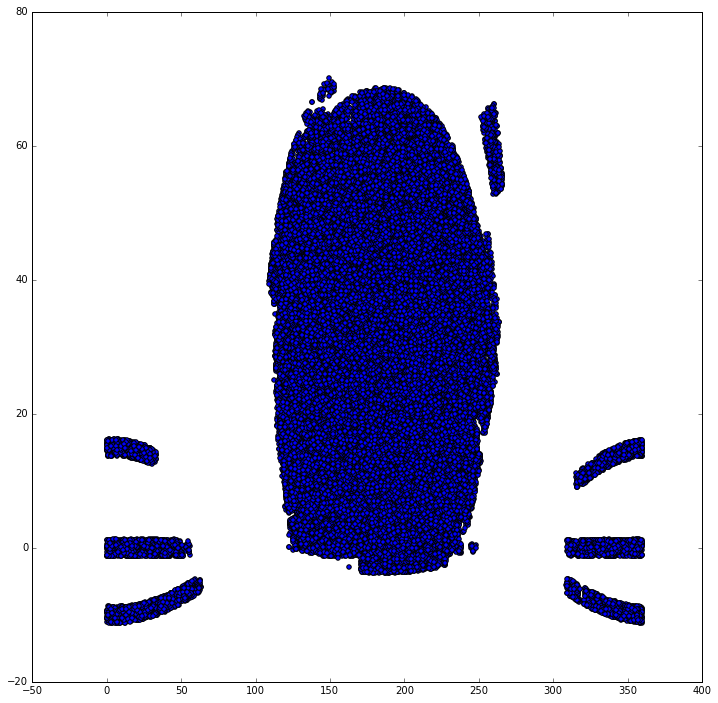

In [31]:
# positions of galaxy targets on the sky ()
plt.scatter(phot_df.ra,phot_df.dec)